In [2]:
import os
from joblib import Parallel, delayed, cpu_count

# Best practice in SLURM: respect what SLURM gave you
n_jobs = int(os.environ.get('SLURM_CPUS_PER_TASK', os.environ.get('SLURM_CPUS_ON_NODE', cpu_count())))

print(f"Using {n_jobs} jobs")  # This will typically print 64 on a full node


Using 32 jobs


In [3]:
import numpy as np
import torch
from network import DarcyGNN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from torch_geometric.data import Data

/home/haltmayermarc/anaconda3/envs/fenics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
checkpoint_path = "/home/haltmayermarc/Samsung_ICML/model/quantile/DarcyGNN/DarcyGNN_MSE_to_WEAK.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(checkpoint_path, map_location=device)

model = DarcyGNN(hidden_dim=32, num_layers=4, edge_dim=6).to(device)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [5]:
class SEGaussianSamplerSVD:
    def __init__(self, pos, sigma=1.0, ell=0.3, mean=1.0, tol=1e-8):
        self.pos = np.asarray(pos, dtype=float)
        self.V = self.pos.shape[0]

        # Pairwise distances
        D = cdist(self.pos, self.pos)

        # Covariance matrix for GRF
        C = (sigma**2) * np.exp(-(D**2) / (2 * ell**2))

        U, s, _ = np.linalg.svd(C, full_matrices=False)

        if np.min(s) < -tol:
            raise ValueError(f"Covariance not PSD: min eigen/singular {np.min(s)} < -tol")
        s = np.clip(s, 0.0, None)

        self.A = U * np.sqrt(s)[None, :]
        self.mean = mean

    def sample(self, rng: np.random.Generator):
        z = rng.normal(0.0, 1.0, size=(self.V,))
        return self.mean + self.A @ z

In [6]:
def compute_kappa_per_element(coarse_elems, kappa_node):
    """
    Compute elementwise-constant kappa on coarse mesh.

    Returns
    -------
    kappa_elem : (N_elem,) ndarray
    """
    kappa_elem = np.zeros(len(coarse_elems))
    for l, elem in enumerate(coarse_elems):
        kappa_elem[l] = np.mean(kappa_node[list(elem)])
    return kappa_elem

def make_fast_kappa_uniform(h, Nx, kappa_elem):
    def kappa(x, y):
        i = min(int(x // h), Nx - 1)
        j = min(int(y // h), Nx - 1)

        # quad index
        q = j * Nx + i

        # two triangles per quad
        # consistent with quads_to_tris(bl-tr)
        if (x - i*h) + (y - j*h) <= h:
            l = 2*q       # lower-left triangle
        else:
            l = 2*q + 1   # upper-right triangle

        return kappa_elem[l]

    return kappa

In [8]:
from LOD import *

H = 2**(-3)
h = 2**(-6)
k = 5

Nx = int(1 / H)
Ny = Nx
refine = int(H / h)

mesh = build_triangular_mesh(Nx, Ny, refine)
    
coarse_nodes = mesh["coarse_nodes"]
coarse_elems = mesh["coarse_elems"]
fine_nodes   = mesh["fine_nodes"]
fine_elems   = mesh["fine_elems"]

In [9]:
adjacency = build_coarse_adjacency_edge(coarse_elems)
fine_in_coarse = precompute_fine_in_coarse(mesh)
pos = fine_nodes
print("Meshing finished...")
    
# GRF parameters
sigma = 1.0
ell = 0.3
    
sampler = SEGaussianSamplerSVD(pos, sigma=sigma, ell=ell, mean=1.0, tol=1e-8)

Meshing finished...


In [10]:
N_h = fine_nodes.shape[0]

In [11]:
print("Building P_h...")
P_h = build_P_triangular(mesh)
# Boundary matrix
print("Building B_H...")
B_H = build_B_H(coarse_nodes, Nx, Ny)
interior = np.where(np.diag(B_H) > 0.5)[0]
# Fine forcing term rhs vector
print("Building f_h...")
f_h = assemble_load_tri(
    fine_nodes, fine_elems, lambda x, y: 1.0
)
# From the 2020 SIAM book
print("Building C_h...")
C_h = build_IH_quasi_interpolation(mesh)

Building P_h...
Building B_H...
Building f_h...
Building C_h...


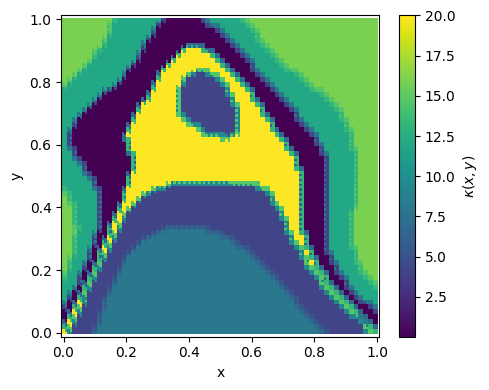

In [12]:
epsi = 0.01
kappa_values = np.array([epsi, 4.0, 8.0, 12.0, 16.0, 20.0])

rng = np.random.default_rng()
a_sample = sampler.sample(rng)
a_sample = np.exp(a_sample)
q_edges = np.quantile(a_sample, np.linspace(0, 1, kappa_values.shape[0]+1))
            
kappa_shuffled = np.asarray(kappa_values, dtype=float).copy()
rng.shuffle(kappa_shuffled)
            
bins = np.searchsorted(q_edges[1:], a_sample, side="right")
bins = np.clip(bins, 0, len(kappa_values)-1)
kappa_node = kappa_shuffled[bins]
            
kappa_elem = compute_kappa_per_element(fine_elems, kappa_node)
kappa = make_fast_kappa_uniform(h, int(1 / h), kappa_elem)

N = 128
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y, indexing="ij")

# vectorize scalar kappa
kappa_vec = np.vectorize(kappa)

K = kappa_vec(X, Y)

plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, K, shading="auto", cmap="viridis")
plt.colorbar(label=r"$\kappa(x,y)$")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [13]:
print("Assemble Stiffness Matrix...")
A_dc, M_dc, sigma = build_fine_element_matrices(mesh, kappa, n_jobs=-1)

print("Assemble global...")
A_h, M_h = assemble_global_from_Adc_Mdc(A_dc, M_dc, sigma, N_h)

print("Assemble load vec...")
# load vector f ≡ 1
f_h = assemble_load_tri(
    fine_nodes, fine_elems, lambda x, y: 1.0
)

Assemble Stiffness Matrix...
Assemble global...
Assemble load vec...


In [14]:
Q_h = computeCorrections(mesh, k, adjacency, fine_in_coarse, A_h, B_H, C_h, kappa, n_jobs=-1)

In [15]:
def downsample_129_to_49(a):
    # reshape to (y, x) grid
    A = a.reshape(129, 129)

    # indices corresponding to 0, 1/8, ..., 1
    idx = np.arange(0, 129, 16)  # [0, 8, 16, ..., 64]

    # downsample to 9x9
    A9 = A[np.ix_(idx, idx)]

    # remove boundary → keep interior 7x7
    A7 = A9[1:-1, 1:-1]

    return A7.reshape(-1)  # (49,)

In [16]:
input = downsample_129_to_49(kappa_node)

ValueError: cannot reshape array of size 4225 into shape (129,129)

In [ ]:
input.shape

(49,)

In [ ]:
path = "/home/haltmayermarc/Samsung_ICML/data/P1_ne0.125_Darcy_5000_quantile_FIXED.npz"
mesh_data = np.load(path, allow_pickle=True)

In [ ]:
pos = torch.tensor(mesh_data["coarse_nodes"], dtype=torch.float)
edge_index = torch.tensor(mesh_data["edges"], dtype=torch.long)

a_node = input
x = torch.tensor(a_node, dtype=torch.float).unsqueeze(-1)

# edge features
i, j = edge_index

pos_i = pos[i]
pos_j = pos[j]

a_i = x[i]
a_j = x[j]

edge_attr = torch.cat([pos_i, pos_j, a_i, a_j], dim=-1)

# Data object
data = Data(
    x=x,
    edge_index=edge_index,
    edge_attr=edge_attr,
    pos=pos
).to(device)

In [ ]:
model.eval()
with torch.no_grad():
    u_pred = model(data)
u_pred = u_pred.squeeze().cpu().numpy()

In [ ]:
u_h_fine = solve_fine_problem(A_h, f_h, fine_nodes)

In [ ]:
V_ms = P_h + Q_h

In [ ]:
V_ms.shape

(81, 16641)

In [ ]:
interior

array([10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30,
       31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51,
       52, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70])

In [ ]:
u_H = np.zeros(81)
u_H[interior] = u_pred
u_h_LOD = V_ms.T @ u_H

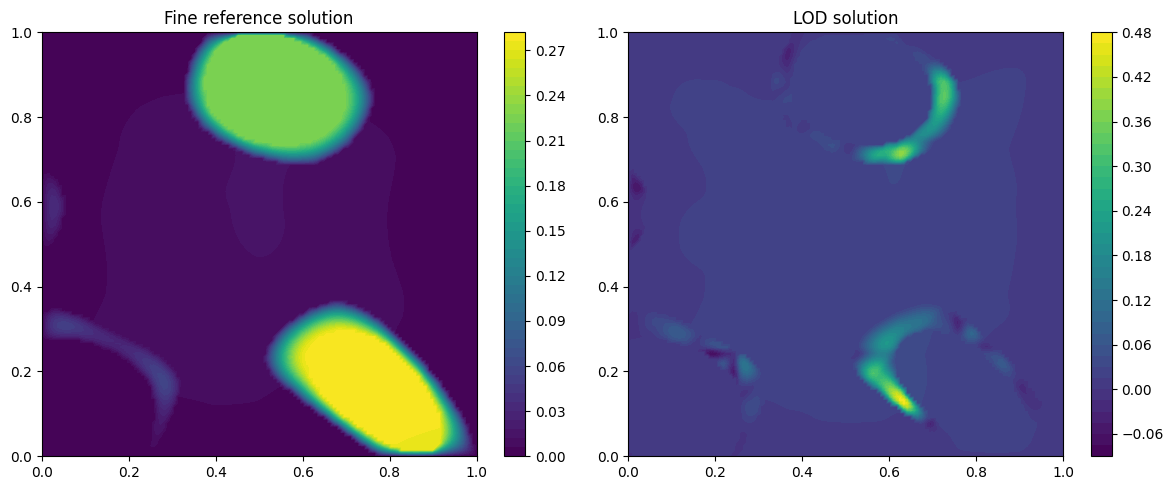

In [ ]:
import matplotlib.tri as mtri

tri = mtri.Triangulation(
    fine_nodes[:,0],
    fine_nodes[:,1],
    fine_elems
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.tricontourf(tri, u_h_fine, levels=50)
plt.colorbar()
plt.title("Fine reference solution")

plt.subplot(1,2,2)
plt.tricontourf(tri, u_h_LOD, levels=50)
plt.colorbar()
plt.title("LOD solution")

plt.tight_layout()
plt.show()

In [ ]:
np.linalg.norm(u_h_LOD - u_h_fine) / np.linalg.norm(u_h_fine)

np.float64(0.885341774346227)